# 1 : Librairies et options

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold


from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # Largeur écran
pd.set_option('display.max_columns', 500)
pd.set_option('mode.chained_assignment', None) # Pour ne pas avoir de message d'erreur quand on crée nouvelle df à partir d'une autre (app)

# 2 : Ouverture du fichier, analyse et simplification

In [2]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


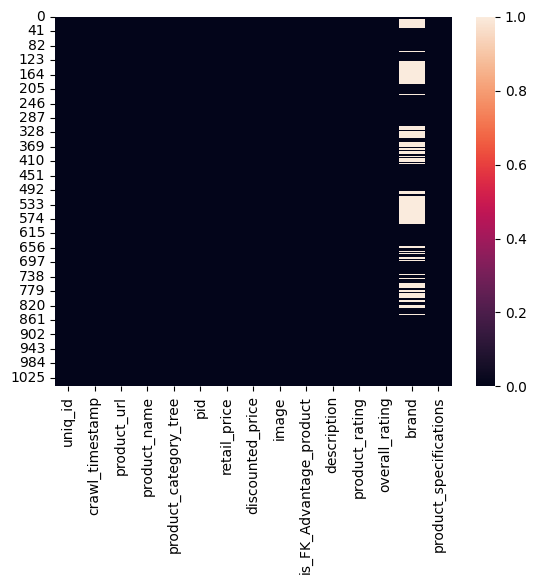

In [5]:
# Visualisation des colonnes vides :
sns.heatmap(df.isna());

- **Quelques lignes avec du vide.**
- **La colonne marqque est plutôt vide.**

In [6]:
df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100

2.165079365079365

In [7]:
df.duplicated().sum()

0

- **Pas de doublons sur lignes vides.**

In [8]:
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

- **Il y a un unique_id, un product_url, un product_name, une pid, une description différente pour chaque ligne.**

In [9]:
# Etude des dates mais à quoi ça correspond ??? :
# transformation :
df['crawl_timestamp'] = pd.to_datetime(df['crawl_timestamp'])
df['crawl_timestamp'] = df['crawl_timestamp'].apply(lambda x : x.date())
df['crawl_timestamp'].nunique()

del df['crawl_timestamp']

- **87 Dates uniques, probablement les j de créations, inutile.**

In [10]:
# Création de colonnes pour chaque niveau de l'arbre de recherche : 
df[['TreeNiv1','TreeNiv2','TreeNiv3','TreeNiv4','TreeNiv5','TreeNiv6', 'TreeNiv7']] = df['product_category_tree'].str.split(' >>', expand=True)

# Suppression de la colonne :
del df['product_category_tree']

In [11]:
# Suppression des [""]:
def supptrop(value):
    try:
        value = value.replace('[','').replace(']','').replace('"','')
        return value
    except:
        return value

Tree = ['TreeNiv1','TreeNiv2','TreeNiv3','TreeNiv4','TreeNiv5','TreeNiv6', 'TreeNiv7']
for T in Tree :
    df[T] = df[T].apply(supptrop)

<Axes: >

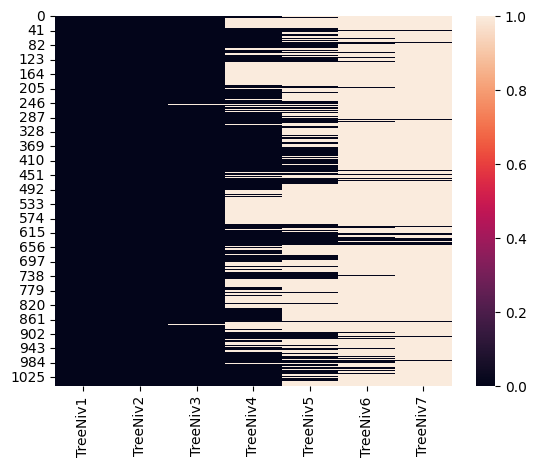

In [12]:
# représentation graphique de l'arbre de recherche :
sns.heatmap(df[['TreeNiv1','TreeNiv2','TreeNiv3','TreeNiv4','TreeNiv5','TreeNiv6', 'TreeNiv7']].isna())

- **On voit que les deux premiers niveaux sont remplis à 100% puis plus on va vers le niveau 7 plus c'est vide, en fonction des produits on a plus ou moins de niveau de catégorie.**

In [13]:
print('Il y a {} catégories de niveau 1.'.format(df['TreeNiv1'].nunique()))
print('Il y a {} catégories de niveau 2.'.format(df['TreeNiv2'].nunique()))
print('Il y a {} catégories de niveau 3.'.format(df['TreeNiv3'].nunique()))
print('Il y a {} catégories de niveau 4.'.format(df['TreeNiv4'].nunique()))
print('Il y a {} catégories de niveau 5.'.format(df['TreeNiv5'].nunique()))
print('Il y a {} catégories de niveau 6.'.format(df['TreeNiv6'].nunique()))
print('Il y a {} catégories de niveau 7.'.format(df['TreeNiv7'].nunique()))

Il y a 7 catégories de niveau 1.
Il y a 62 catégories de niveau 2.
Il y a 241 catégories de niveau 3.
Il y a 349 catégories de niveau 4.
Il y a 297 catégories de niveau 5.
Il y a 117 catégories de niveau 6.
Il y a 57 catégories de niveau 7.


- **Remplir les colonnes vers la droite???**

In [14]:
df['pid'].head()

del df['pid']

- **Je ne sais pas ce que c'est.**

In [15]:
df[['retail_price','discounted_price']].head()

del df['retail_price']
del df['discounted_price']

- **Prix de base et prix réduit.**

In [16]:
df['image'].head()

0    55b85ea15a1536d46b7190ad6fff8ce7.jpg
1    7b72c92c2f6c40268628ec5f14c6d590.jpg
2    64d5d4a258243731dc7bbb1eef49ad74.jpg
3    d4684dcdc759dd9cdf41504698d737d8.jpg
4    6325b6870c54cd47be6ebfbffa620ec7.jpg
Name: image, dtype: object

- **C'est la seconde partie qui nous interesse.**

In [17]:
df['is_FK_Advantage_product'].value_counts()

del df['is_FK_Advantage_product']

- **Qu'est ce que c'est???**

In [18]:
# Description des produits :
df['description']

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

- **C'est la partie qui nous interesse.**

In [19]:
# Notes sur les produits :
df['product_rating'].value_counts().head()

No rating available    889
5                       43
4                       21
3                       12
1                       10
Name: product_rating, dtype: int64

In [20]:
df['overall_rating'].value_counts().head()

No rating available    889
5                       43
4                       21
3                       12
1                       10
Name: overall_rating, dtype: int64

In [21]:
df[df['product_rating'] != df['overall_rating']]

,uniq_id,product_url,product_name,image,description,product_rating,overall_rating,brand,product_specifications,TreeNiv1,TreeNiv2,TreeNiv3,TreeNiv4,TreeNiv5,TreeNiv6,TreeNiv7


In [22]:
del df['overall_rating']
del df['product_rating']

- **Trés peu de notes...**
- **Meme colonne...**

In [23]:
# Marques :
df['brand'].value_counts(dropna = False)

del df['brand']

- **Quand même pas mal de vide dans cette colonne.**

In [24]:
df['product_specifications'][1]

'{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "value"=>"Mediam"}, {"key"=>"Length", "value"=>"30 inch"}, {"key"=>"Width", "value"=>"60 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"3"}, {"key"=>"Sales Package", "value"=>"3 Bath Towel"}]}'

- **A voir si utilisable.**

In [25]:
df.head(2)

,uniq_id,product_url,product_name,image,description,product_specifications,TreeNiv1,TreeNiv2,TreeNiv3,TreeNiv4,TreeNiv5,TreeNiv6,TreeNiv7
0,55b85ea15a1536d46b7190ad6fff8ce7,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None


# 3 : Nettoyage des données Texte

In [26]:
import nltk
nltk.download('popular', quiet = True)

True

In [27]:
# Taille des nom de produits :
print('La longueur minimum du nom de produit est de', df['product_name'].apply(lambda x : len(x.split(' '))).min())
print('La longueur maximum du nom de produit est de', df['product_name'].apply(lambda x : len(x.split(' '))).max())

La longueur minimum du nom de produit est de 2
La longueur maximum du nom de produit est de 27


In [28]:
# Nb de mots dans chaque phrase :
print('La longueur minimum de la description est de', df['description'].apply(lambda x : len(x.split(' '))).min())
print('La longueur maximum de la description est de', df['description'].apply(lambda x : len(x.split(' '))).max())

La longueur minimum de la description est de 18
La longueur maximum de la description est de 589


- **Intéressant de coupler les informations de ces deux colonnes, le nom du produit pouvant être trés long.**

In [29]:
# Création de la variable :
df['DescriptionGlobale'] = df['product_name'] + df['description']
df['DescriptionGlobale'].head(3)

0    Elegance Polyester Multicolor Abstract Eyelet ...
1    Sathiyas Cotton Bath TowelSpecifications of Sa...
2    Eurospa Cotton Terry Face Towel SetKey Feature...
Name: DescriptionGlobale, dtype: object

In [30]:
# Nb de mots dans chaque phrase :
print('La longueur minimum de la description Globale est de', df['DescriptionGlobale'].apply(lambda x : len(x.split(' '))).min())
print('La longueur maximum de la description Globale est de', df['DescriptionGlobale'].apply(lambda x : len(x.split(' '))).max())

La longueur minimum de la description Globale est de 21
La longueur maximum de la description Globale est de 593


In [31]:
# Nb de replicats de mots dans chaque phrase :
df['DescriptionGlobale'].apply(lambda x : nltk.FreqDist(x.split(" "))).head(5)

0    {'Elegance': 4, 'Polyester': 6, 'Multicolor': ...
1    {'Sathiyas': 4, 'Cotton': 3, 'Bath': 6, 'Towel...
2    {'Eurospa': 6, 'Cotton': 5, 'Terry': 5, 'Face'...
3    {'SANTOSH': 4, 'ROYAL': 4, 'FASHION': 4, 'Cott...
4    {'Jaipur': 4, 'Print': 5, 'Cotton': 5, 'Floral...
Name: DescriptionGlobale, dtype: object

In [32]:
# Tokenisation + mise en minuscule :
def tokenizer(value):
    value = value.lower()
    value = nltk.word_tokenize(value)
    return value

df['DescriptionGlobaleToken'] = df['DescriptionGlobale']
df['DescriptionGlobaleToken'] = df['DescriptionGlobaleToken'].apply(tokenizer)
df['DescriptionGlobaleToken'].head(3)

0    [elegance, polyester, multicolor, abstract, ey...
1    [sathiyas, cotton, bath, towelspecifications, ...
2    [eurospa, cotton, terry, face, towel, setkey, ...
Name: DescriptionGlobaleToken, dtype: object

In [33]:
# Suppression des stops words (en anglais) et des ponctuations :
def tokensWithoutStopWords(phrase) :
    tokensWSW = []
    for words in phrase:
        if words not in nltk.corpus.stopwords.words("english"):
            tokensWSW.append(words)
    return tokensWSW

df['DescriptionGlobaleToken'] = df['DescriptionGlobaleToken'].apply(tokensWithoutStopWords)
df['DescriptionGlobaleToken'] = df['DescriptionGlobaleToken'].apply(lambda x : [word for word in x if word.isalpha()]) # Suppression des .,;()...
df['DescriptionGlobaleToken'].head(3)

0    [elegance, polyester, multicolor, abstract, ey...
1    [sathiyas, cotton, bath, towelspecifications, ...
2    [eurospa, cotton, terry, face, towel, setkey, ...
Name: DescriptionGlobaleToken, dtype: object

In [34]:
# Nb de mots dans chaque phrase aprés nettoyage :
print('La longueur minimum de la description Globale est de', df['DescriptionGlobaleToken'].apply(lambda x : len(x)).min())
print('La longueur maximum de la description Globale est de', df['DescriptionGlobaleToken'].apply(lambda x : len(x)).max())
print('Le nombre de repliquat minimum sur toute la DF est de', pd.DataFrame(df['DescriptionGlobaleToken'].sum()).value_counts().min())
print('Le nombre de repliquat maximum sur toute la DF est de', pd.DataFrame(df['DescriptionGlobaleToken'].sum()).value_counts().max())

La longueur minimum de la description Globale est de 10
La longueur maximum de la description Globale est de 365
Le nombre de repliquat minimum sur toute la DF est de 1
Le nombre de repliquat maximum sur toute la DF est de 632


In [35]:
# Stemming :
from nltk.stem import SnowballStemmer
stem_en = SnowballStemmer("english")

def Stemming(tokens) :
    tokensStem = []
    for words in tokens:
        tokensStem.append(stem_en.stem(words))
    return tokensStem

df['DescriptionGlobaleToken'] = df['DescriptionGlobaleToken'].apply(Stemming)
df['DescriptionGlobaleToken'].head(3)

0    [eleg, polyest, multicolor, abstract, eyelet, ...
1    [sathiya, cotton, bath, towelspecif, sathiya, ...
2    [eurospa, cotton, terri, face, towel, setkey, ...
Name: DescriptionGlobaleToken, dtype: object

In [36]:
# Nb de mots dans chaque phrase aprés nettoyage et Stemming :
print('La longueur minimum de la description Globale est de', df['DescriptionGlobaleToken'].apply(lambda x : len(x)).min())
print('La longueur maximum de la description Globale est de', df['DescriptionGlobaleToken'].apply(lambda x : len(x)).max())
print('Le nombre de repliquat minimum sur toute la DF est de', pd.DataFrame(df['DescriptionGlobaleToken'].sum()).value_counts().min())
print('Le nombre de repliquat maximum sur toute la DF est de', pd.DataFrame(df['DescriptionGlobaleToken'].sum()).value_counts().max())

La longueur minimum de la description Globale est de 10
La longueur maximum de la description Globale est de 365
Le nombre de repliquat minimum sur toute la DF est de 1
Le nombre de repliquat maximum sur toute la DF est de 870


In [37]:
# Lemmatizing :
'''import spacy
nlp = spacy.load('en_core_web_sm')

def Lemma(tokens) :
    tokens = ' '.join(tokens)
    sent_tokens = nlp(tokens)
    return list(sent_tokens)

df['DescriptionGlobaleToken'] = df['DescriptionGlobaleToken'].apply(Lemma)
df['DescriptionGlobaleToken'].head(3)'''

"import spacy\nnlp = spacy.load('en_core_web_sm')\n\ndef Lemma(tokens) :\n    tokens = ' '.join(tokens)\n    sent_tokens = nlp(tokens)\n    return list(sent_tokens)\n\ndf['DescriptionGlobaleToken'] = df['DescriptionGlobaleToken'].apply(Lemma)\ndf['DescriptionGlobaleToken'].head(3)"

- **J'aurai préféré utiliser celui-la mais j'ai un problème de chargement que je n'ai pas sur Google Colab???**

In [38]:
# Remettre les mots restant en une seule phrase :
df['DescriptionGlobaleToken'] = df['DescriptionGlobaleToken'].apply(lambda x : ' '.join(str(v) for v in x))

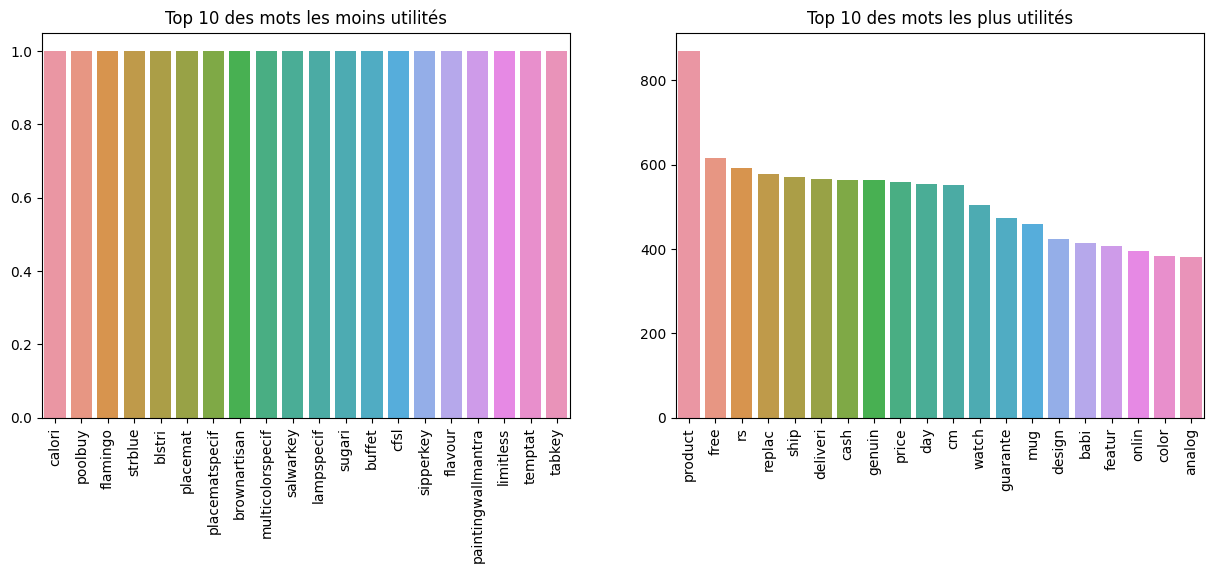

In [39]:
# Graphique des mots les plus utilisés dans toute la DF :
values = ' '.join(str(v) for v in df['DescriptionGlobaleToken'])
Freq = nltk.FreqDist(values.split((' ')))
Freq = pd.DataFrame.from_dict(Freq, orient='index').sort_values(0, ascending = False)
Freq = Freq.reset_index()


plt.subplots(1,2, figsize = (15,5))
plt.subplot(121)
sns.barplot(x = Freq['index'].tail(20), y = Freq[0].tail(20))
plt.title('Top 10 des mots les moins utilités')
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('')

plt.subplot(122)
sns.barplot(x = Freq['index'].head(20), y = Freq[0].head(20))
plt.title('Top 10 des mots les plus utilités')
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('')

plt.show()

# 4 : Visualisation

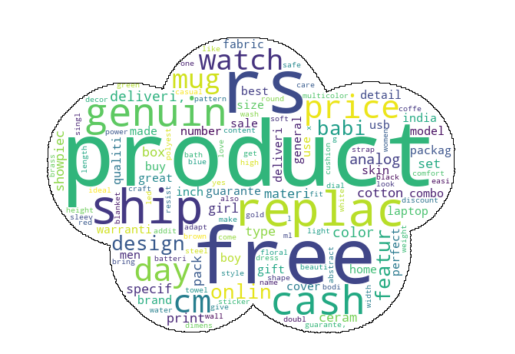

In [40]:
# Nuage de mots :
mask = np.array(Image.open("nuage.png"))
mask[mask == 1] = 255
wordcloud = WordCloud(width=480, height=480, max_font_size=200, min_font_size=10,background_color='white', mask = mask, contour_width = 0.1)

Mots = list(df['DescriptionGlobaleToken'])
Mots = ', '.join(Mots)
Mots = [m for m in Mots.split(' ')]

wordcloud.generate_from_frequencies(nltk.FreqDist(Mots))
plt.figure()

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# 5 : Transformation de la colonne Target

In [41]:
df['TreeNiv2'].value_counts().sort_values()

 Beauty Accessories          1
 Dinnerware & Crockery       1
 Garden & Leisure            1
 Clocks                      1
 Housekeeping & Laundry      1
                          ... 
 Showpieces                 71
 Coffee Mugs                74
 Infant Wear                84
 Laptop Accessories         87
 Wrist Watches             149
Name: TreeNiv2, Length: 62, dtype: int64

In [42]:
df['TreeNiv1Texte'] = df['TreeNiv1']
df['TreeNiv1'] = df['TreeNiv1'].factorize()[0]

# 6 : Exporter le fichier

In [43]:
df.to_csv('DataP6.csv',index=False)